In [1]:
!pip install nltk
!pip install konlpy

     |████████████████████████████████| 19.4MB 74.1MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 3.6MB 53.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
#구글드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls '/content/drive/'

'My Drive'


In [4]:
import nltk
import konlpy

In [5]:
nltk.download

konlpy.__version__

'0.5.2'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from konlpy.tag import Okt
import urllib.request
%matplotlib inline
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f90345f2a58>)

In [8]:
train=pd.read_table("ratings_train.txt")
test=pd.read_table("ratings_test.txt")



# 1.EDA



In [9]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [13]:
train['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [14]:
test['label'].value_counts()

1    25173
0    24827
Name: label, dtype: int64

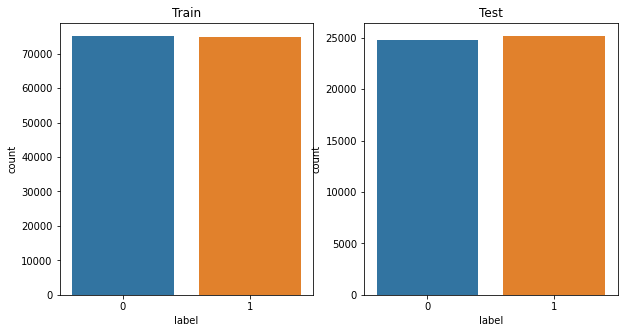

In [15]:
f,ax=plt.subplots(1,2,figsize=[10,5])

sns.countplot('label',data=train,ax=ax[0])
ax[0].set_title("Train")

sns.countplot('label',data=test,ax=ax[1])
ax[1].set_title("Test")
plt.show()

In [16]:
train['document'].isnull().sum()

5

In [17]:
#null 값이 있는 곳의 위치 확인
train.loc[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [18]:
train=train.dropna(axis=0)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [20]:
uniq=np.unique(train['document'])

In [21]:
len(uniq)

146182

In [22]:
#중복 데이터 제거

train.drop_duplicates(subset=['document'],inplace=True)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [24]:
train['label'].value_counts()

0    73342
1    72840
Name: label, dtype: int64

# 2. 데이터 전처리

In [25]:
#정규표현식을 이용한 특수문자 등 제거

train['document']=train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [26]:
#공백 처리된 데이터 NaN 값으로 변경

train['document'].replace("",np.nan,inplace=True)

In [27]:
train.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [28]:
train.loc[train.document.isnull()][:10]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2327,9317820,NaN,1
2648,423224,NaN,1
2834,3645129,NaN,0


In [29]:
train=train.dropna(axis=0)
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [30]:
len(train)

145791

In [31]:
test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
# test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 49157


2-1 토큰화

In [32]:
#stopwords 정의, 경우에 따라 추가 가능!
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [33]:
okt=Okt()

In [34]:
# #트레인 데이터 토큰화
# X_train=[]
# for sentence in train['document']:
#   temp_X=[]
#   temp_X=okt.morphs(sentence,stem=True)
#   temp_X=[word for word in temp_X if word not in stopwords]
#   X_train.append(temp_X)


# #시간 절약을 위한 토큰화된 데이터 드라이브 저장
# with open('/content/drive/My Drive/xtrain.txt','wb') as f:
#   pickle.dump(X_train,f)

In [35]:
#시간 절약을 위한 데이터 로딩

with open('/content/drive/My Drive/xtrain.txt','rb') as file:
  X_train=[]
  while True:
    try:
      data=pickle.load(file)
    except EOFError:
      break
    X_train=data


In [36]:
X_train[:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [37]:
#테스트 테이터 토큰화

# X_test = []
# for sentence in test['document']:
#     temp_X = []
#     temp_X = okt.morphs(sentence, stem=True) # 토큰화
#     temp_X = [word for word in temp_X if not word in stopwords]
#     X_test.append(temp_X)

# with open('/content/drive/My Drive/xtest.txt','wb') as f:  #피클로 토큰화된 데이터 저장
#   pickle.dump(X_test,f)

KeyboardInterrupt: ignored

In [38]:
with open('/content/drive/My Drive/xtest.txt','rb') as file:
  X_test=[]
  data=pickle.load(file)
  X_test=data


2-2 정수인코딩


In [39]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [40]:
#단어의 등장 빈도수가 많을 수록 낮은 인덱스를 부여받는다.

tokenizer.word_index
len(tokenizer.word_index)

43752

In [41]:
#빈도수가 3회 미만으로 낮은 단어 확인
#빈도수가 너무 낮은 단어를 피팅에서 제외하기 위함

threshold = 3 #기준
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0


for k,v in tokenizer.word_counts.items():
  total_freq=total_freq+v

  if(v<threshold):
    rare_cnt+=1
    rare_freq+=v


print('단어 집합의 크기: ',total_cnt)
print('등장 빈도가 3회 미만인 단어의 수: ',rare_cnt )
print('단어 집합에서 희귀 단어의 비율: ',(rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ',(rare_freq/total_freq)*100)


단어 집합의 크기:  43752
등장 빈도가 3회 미만인 단어의 수:  24337
단어 집합에서 희귀 단어의 비율:  55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  1.8715872104872904


In [42]:
#전체 단어 개수에서 등장 빈도수가 3회 미만인 단어들을 제거하여 단어 집합 크기 제한
#0번 패딩을 고려한 +1

vocab_size=total_cnt-rare_cnt+1
print("단어 집합의 크기: ",vocab_size)

단어 집합의 크기:  19416


In [43]:
#각 리뷰에 포함된 단어의 인덱스가 vocab_size를 넘어갈 경우 인코딩에서 제외
#즉 인덱스 번호가 19416 이상일 경우, 중요하지 않다고 판단하여 제외

tokenizer=Tokenizer(vocab_size)  #가장 빈도가 높은 vocab_size(19416)만큼 사용
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

print(X_train[:5])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9], [6492, 105, 8118, 218, 56, 4, 26, 3603], [1023, 29, 9145, 24, 833, 1, 2579, 21, 1108, 240, 14243, 1076, 254, 240]]


In [44]:
y_train=np.array(train['label'])
y_test=np.array(test['label'])

In [45]:
#빈 샘플 제거 
#즉 위에서 피팅을 진행하며 빈도수가 2회 이하인 단어를 삭제했으므로, 
#그 단어들 만으로 구성된 문장들은 빈 샘플이 됐고, 그러한 빈 샘플들을 제거

drop_train=[index for index,sentence in enumerate(X_train) if len(sentence)<1]
drop_test=[index for index,sentence in enumerate(X_test) if len(sentence)<1]

In [46]:
#제거

X_train=np.delete(X_train,drop_train,axis=0)
y_train=np.delete(y_train,drop_train,axis=0)

print(len(X_train))
print(len(y_train))

145162
145162


In [47]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

48747
48747


2-3 패딩



리뷰의 최대 길이:  69
리뷰의 평균 길이:  10.812485361182679


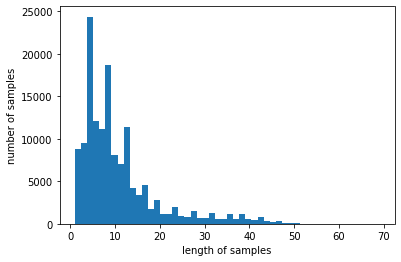

In [48]:
print('리뷰의 최대 길이: ',max(len(l) for l in X_train))
print('리뷰의 평균 길이: ',sum(map(len,X_train))/len(X_train)) #map(a,b) : iterable b에 대하여 a 함수 적용  
plt.hist([len(s) for s in X_train],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
def below_threshold_len(max_len,nested_list):
  cnt=0
  for s in nested_list:
    if(len(s)<=max_len):
      cnt=cnt+1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len,(cnt/len(nested_list))*100))

In [50]:
max_len=30
below_threshold_len(max_len,X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [51]:
#94 이상의 샘플들이 길이기 30 이하이므로 30의 길이로 패딩

X_train=pad_sequences(X_train,maxlen=max_len)
X_test=pad_sequences(X_test,maxlen=max_len)

In [52]:
X_train[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    50,   454,
           16,   260,   659],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   933,   457,    41,   602,     1,   214,  1449,    24,
          961,   675,    19],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   386,  2444,  2315,  5671,
            2,   222,     9],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  6492,   105,  8118,   218,    56,
            4,    26,  3603],
       [    0,     0,     0,

# 3. LSTM을 이용한 딥러닝 신경망 구축

In [53]:
#모듈 로딩

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #과적합 방지를 위한 EarlyStopping

In [54]:
#신경망 구성

model=Sequential()
model.add(Embedding(vocab_size,100))  #단어임베딩, 샘플 크기 = 사용할 단어 개수, 차원 = 100
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [56]:
#더이상 loss가 감소하지 않는다면 학습종료

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)


#모델 성능(정확도)가 가장 좋을 경우만 저장
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)



In [58]:
#모델 컴파일 및 학습

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(X_train,y_train,epochs=15,callbacks=[es,mc],batch_size=60,validation_split=0.2)


Epoch 1/15
1935/1936 [============================>.] - ETA: 0s - loss: 0.3876 - acc: 0.8254
Epoch 00001: val_acc improved from -inf to 0.84793, saving model to best_model.h5
1936/1936 [==============================] - 39s 20ms/step - loss: 0.3876 - acc: 0.8254 - val_loss: 0.3514 - val_acc: 0.8479
Epoch 2/15
1936/1936 [==============================] - ETA: 0s - loss: 0.2992 - acc: 0.8725
Epoch 00002: val_acc improved from 0.84793 to 0.85231, saving model to best_model.h5
1936/1936 [==============================] - 38s 20ms/step - loss: 0.2992 - acc: 0.8725 - val_loss: 0.3420 - val_acc: 0.8523
Epoch 3/15
1935/1936 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.8966
Epoch 00003: val_acc did not improve from 0.85231
1936/1936 [==============================] - 38s 20ms/step - loss: 0.2474 - acc: 0.8966 - val_loss: 0.3700 - val_acc: 0.8496
Epoch 4/15
1936/1936 [==============================] - ETA: 0s - loss: 0.2030 - acc: 0.9169
Epoch 00004: val_acc did not improve

In [59]:
with open('/content/drive/My Drive/best_model.h5','wb') as f:  
  pickle.dump('best_model.h5',f)

In [60]:
with open('/content/drive/My Drive/best_model.h5','rb') as file:
  data=pickle.load(file)

In [61]:
#테스트 
loaded=load_model(data)
print("\n 테스트 정확도: %.4f" %(loaded.evaluate(X_test,y_test)[1]))

1524/1524 [==============================] - 5s 3ms/step - loss: 0.3495 - acc: 0.8481

 테스트 정확도: 0.8481


In [62]:
model.evaluate(X_test,y_test)

1524/1524 [==============================] - 5s 3ms/step - loss: 0.5279 - acc: 0.8369


[0.5279423594474792, 0.8369130492210388]

In [63]:
#새로운 데이터 입력을 위한 전처리 과정 통합

def preprocessing(sentences):
  sent_list=[]
  for sentence in sentences:
    temp=[]
    sentence=" ".join(sentence)
    sentence=sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    temp=okt.morphs(sentence,stem=True)
    temp=[word for word in temp if word not in stopwords]
    sent_list.append(temp)

  tokenizer.fit_on_texts(sent_list)
  sent_list=tokenizer.texts_to_sequences(sent_list)
  sent_list=pad_sequences(sent_list,maxlen=max_len)

  return sent_list

In [118]:
#테스트

sentences=[['올해 최고의 영화입니다!'],['재밌어요'],['재미없어요'],['너무 재밌었어요!'],['연기를 너무 못함']]


In [119]:
a=preprocessing(sentences)
b=model.predict(a)
for i in b:
  print(i)

  if i[0]>=0.5:
    print('이 리뷰는 긍정리뷰입니다')

  else:
    print('이 리뷰는 부정리뷰입니다')

[0.9776153]
이 리뷰는 긍정리뷰입니다
[0.95357025]
이 리뷰는 긍정리뷰입니다
[0.01004769]
이 리뷰는 부정리뷰입니다
[0.98693675]
이 리뷰는 긍정리뷰입니다
[0.02229587]
이 리뷰는 부정리뷰입니다
[0.99923503]
이 리뷰는 긍정리뷰입니다


In [71]:
def sentiment(sentences):
  a=preprocessing(sentences)
  b=model.predict(a)


  num_of_posi=0   #긍정 트윗 개수
  num_of_nega=0   #부정 트윗 개수
  

  for sent,pred in zip(sentences,b):
    if pred[0]>=0.5:
      print(sent[0])
      print("Positive. \n")
      num_of_posi +=1
    else:
      print(sent[0])
      print("Negative.\n")
      num_of_nega+=1

  print("전체 트윗중 부정 트윗의 비율(\'%\') : ",num_of_nega/(num_of_posi+num_of_nega)*100)
  print("전체 트윗중 긍정 트윗의 비율(\'%\') : ",num_of_posi/(num_of_posi+num_of_nega)*100)

In [74]:
!pip install twitterscraper
!pip install tweepy

     |████████████████████████████████| 92kB 5.3MB/s 
  Created wheel for twitterscraper: filename=twitterscraper-1.4.0-cp36-none-any.whl size=11347 sha256=4b218146b95d586f3ca7ac868263191b8db9c8936cf7e2bd642866174d263f06
  Stored in directory: /root/.cache/pip/wheels/c2/9c/8b/7393e7bdc8abe6ce0d46c2ffae2035a1a2080a97ff0ddbdde6
Successfully built twitterscraper


In [75]:
import twitterscraper
from twitterscraper import query_tweets

INFO: {'User-Agent': 'Opera/9.80 (X11; Linux i686; Ubuntu/14.10) Presto/2.12.388 Version/12.16'}


In [76]:
import tweepy


consumer_key = "PqICmArGSxkIHNtq4wbGykpkv"

consumer_secret = "ZRp5ilQvwOKj6jExUEIKQC5OoICGSbWUH0pok1xZ7ZvRoAWUyO"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)



# access 토큰 요청

access_token = "1244509487127379970-Oz4UMNX4N0ydH4OtYTqnolaxxgaDhC"

access_token_secret = "mqNXpnGbnh2CtmRH4j7BSLzssfcIQSahqoKuNNPqIjvAv"

auth.set_access_token(access_token, access_token_secret)



# twitter API 생성  

api = tweepy.API(auth)

In [77]:
def get_tweets(query, count = 10000): 

  
    tweets = [] 

    try: 
    
        fetched_tweets = api.search(q = query, count = count) 
        
        for tweet in fetched_tweets: 
            
            parsed_tweet = []
             
            parsed_tweet.append(tweet.text)
            
  

            if tweet.retweet_count > 0:   #리트윗은 한번만 기록

                if parsed_tweet not in tweets: 
                    tweets.append(parsed_tweet) 
            else: 
                tweets.append(parsed_tweet) 


        return tweets

    except tweepy.TweepError as e: 
        print("Error : " + str(e))


In [126]:
tweets_list=get_tweets("진비빔면")


In [ ]:
#크롤링한 트윗 파일로 저장
with open('/content/drive/My Drive/tweets_list.txt','wb') as f:
  pickle.dump(tweets_list,f)

In [ ]:
with open('/content/drive/My Drive/tweets_list.txt','rb') as file:
  tweets_list=pickle.load(file)

In [127]:
sentiment(tweets_list)

@weeeeeuri0219 칼비빔면 진비빔면 진짜쫄면 팔도비빔면중 머가맛있지?!?
Negative.

점심 진비빔면!!! 팔도꺼하고는 좀 다른맛!!! 맛있어!!! https://t.co/DsxzyIuUI4
Positive. 

@vntsla 웅냥 남부 비와 ㅇ0ㅇ 후후 진비빔면이었다구~! 먹고 부족해서 밥두 먹어떠
Negative.

진비빔면 조지기~
Negative.

#귤귤_테이스팅
오뚜기 진비빔면
탱글탱글 쫀쫀한 면발
그리고 새콤매콤한 소스
거기다 수육 올리니 금상첨화 https://t.co/iztC0hOFQb
Positive. 

례~~~드디어 마트에서진비빔면판다 빨리먹어야쥐~~~
Positive. 

누가 우리집 와서 진비빔면 끓여죠.. 아니다.. 내가 끓여 먹을게.. 아 ㅈㄴ 귀차나..
Negative.

@FF14_heuglyeon 너무 많아서 남겼어요...ㅋㅋㅋㅋㅋㅋㅋ진비빔면 양 짱많던데요
Positive. 

@jeju9am9yul 진비빔면
Negative.

아 진비빔면 너무 맵다
Negative.

으아아아아아아앙 뽀글이 먹으러 갈꺼야아아아아아아아 오늘은 비빔면을 먹어주게따아아아아아ㅏㅇ 결코 어제 밤에 엄빠가 먹는걸 보고 나고 먹고 싶어진게 맞아
Positive. 

진비빔면에 식초 쳐서 먹으면 맛있읍니다 그냥먹으니까 입에안맞음
Negative.

@Only_Luv_BTS 크킄ㅋ 저번에 진비빔면 먹어봤는데 별루였어요..팔도가 짱
Negative.

@13yo_man 마자 진비빔면 양많고 존맛ㅜ 꼭 먹어봐ㅠ 존맛이야 진짜루ㅠ
Negative.

@13yo_man 님 진비빔면 존맛이야
Negative.

@changbinx3x 앵그리 너구리가 있었으면 먹었을 텐데...
진비빔면에 팔도비빔면도 있어요
Positive. 

@P_Simsya 헉 저희집에도 진비빔면있어요! 제입맛에는 꽤 맛있었던거 같아요!!😊 저...저녁을 5시쯤 먹어서 지금와서 보니 배고프더라구요...뭐먹을수도없어서 굶주린채로있지만...ㅜㅡㅜ어서 내일되고 학교도마쳤음좋겠네요! 진비